In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras
import time

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
temps = pd.read_csv("/content/drive/MyDrive/data/Time series forecasting/daily-minimum-temperatures-in-me.csv",parse_dates=[0], index_col=0)

In [4]:
temps.head(5)

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [5]:
temps.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  3650 non-null   float64
dtypes: float64(1)
memory usage: 57.0 KB


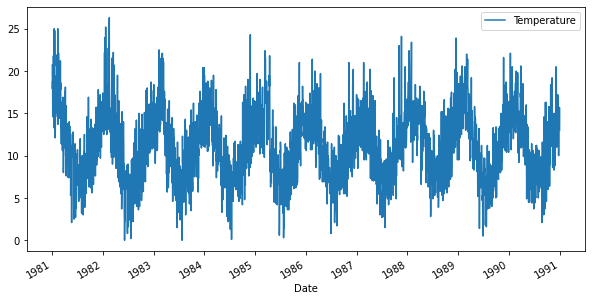

In [6]:
temps.plot(figsize=(10,5))
plt.show()

In [7]:
temps = temps.interpolate()


In [8]:
split_time = 2000
time_train = temps.index[:split_time]
x_train = temps.Temperature.values[:split_time]
time_valid = temps.index[split_time:]
x_valid = temps.Temperature.values[split_time:]

shuffle_buffer_size = 1000
window_size = 30
batch_size = 32

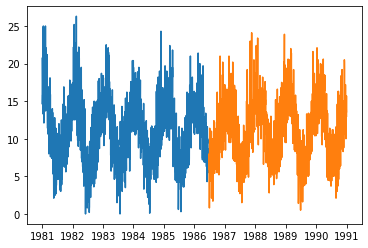

In [9]:
plt.plot(time_train,x_train)
plt.plot(time_valid,x_valid)

## 1 - Linear regression (DNN)

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [11]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>
Layer weights [array([[ 0.05915903],
       [ 0.0708387 ],
       [ 0.07272706],
       [ 0.03602376],
       [-0.08756554],
       [-0.10668126],
       [ 0.15434873],
       [-0.05857217],
       [-0.11700998],
       [-0.04013438],
       [ 0.19179827],
       [-0.21225642],
       [ 0.32070175],
       [-0.15388551],
       [-0.04581379],
       [ 0.17400289],
       [-0.14873338],
       [ 0.03357312],
       [ 0.09440021],
       [-0.02072268],
       [-0.27067685],
       [ 0.23400266],
       [ 0.15092535],
       [-0.04103249],
       [-0.01260297],
       [ 0.12374035],
       [ 0.07106785],
       [ 0.184356  ],
       [-0.13907239],
       [ 0.47380728]], dtype=float32), array([0.00580429], dtype=float32)]


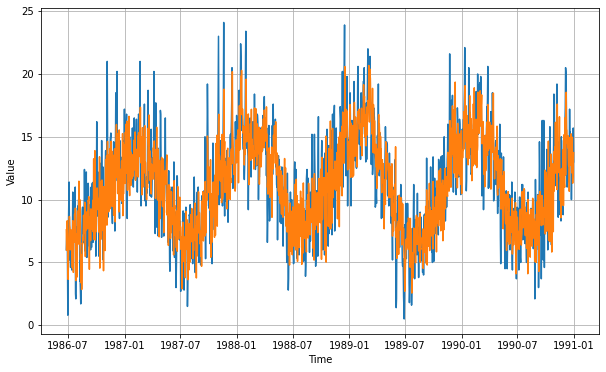

In [12]:
forecast = []

for time in range(len(temps) - window_size):
    forecast.append(model.predict(temps.Temperature.values[time :time + window_size][np.newaxis]))
    

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.158718

## Model 2

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [15]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

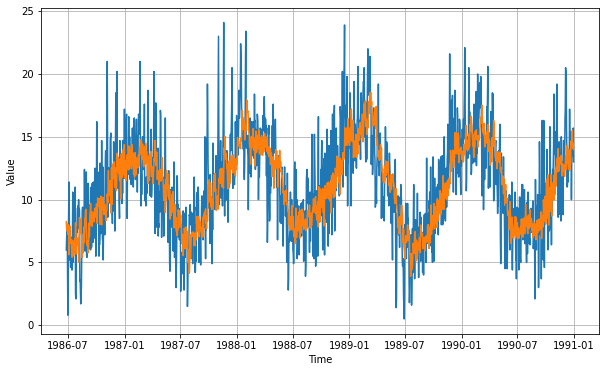

In [16]:
forecast = []

for time in range(len(temps) - window_size):
    forecast.append(model.predict(temps.Temperature.values[time :time + window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.1916814

In [18]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

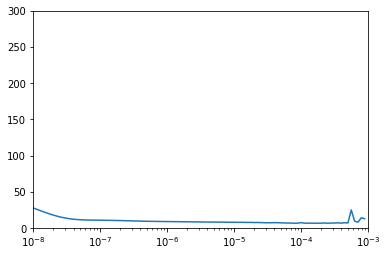

In [19]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

## RNN

In [20]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,verbose=0, callbacks=[lr_schedule])

(1e-08, 0.0001, 0.0, 30.0)

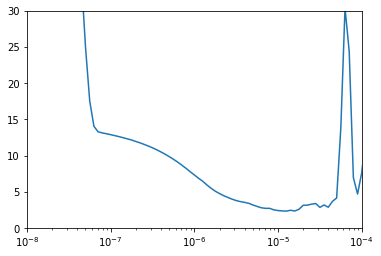

In [22]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [23]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=3e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400,verbose=0)

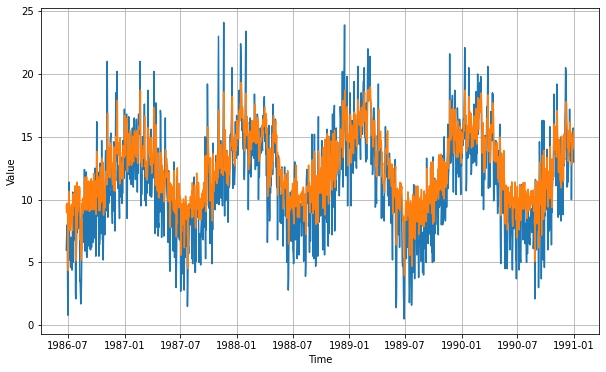

In [24]:
forecast = []

for time in range(len(temps) - window_size):
    forecast.append(model.predict(temps.Temperature.values[time :time + window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [25]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.1199777

## LSTM

In [26]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule],verbose=0)

(1e-08, 0.0001, 0.0, 30.0)

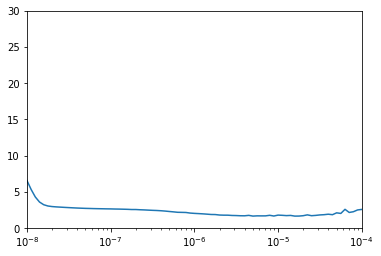

In [27]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [28]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=0)

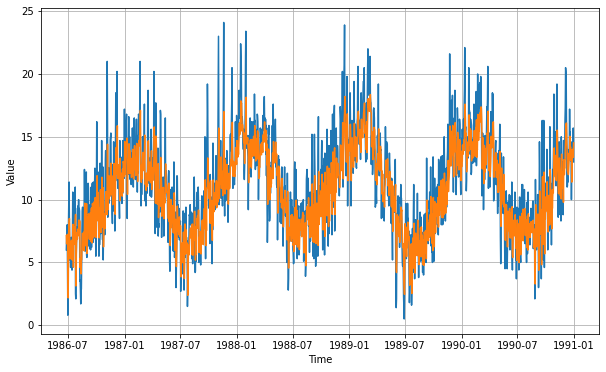

In [29]:
forecast = []

for time in range(len(temps) - window_size):
    forecast.append(model.predict(temps.Temperature.values[time :time + window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [30]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

1.8779368

<Figure size 432x288 with 0 Axes>

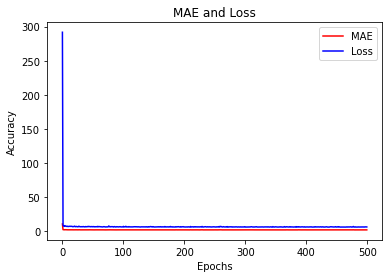

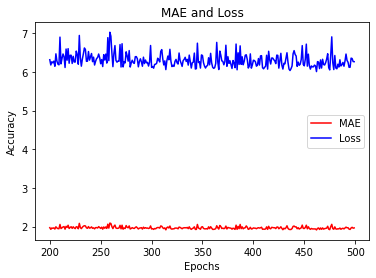

<Figure size 432x288 with 0 Axes>

In [31]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [32]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss=tf.keras.losses.MeanSquaredLogarithmicError(), optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

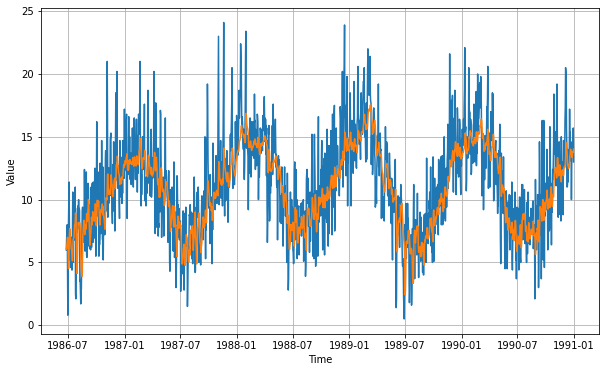

In [33]:
forecast = []

for time in range(len(temps) - window_size):
    forecast.append(model.predict(temps.Temperature.values[time :time + window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [34]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.0645797

## CNN - LSTM - RNN

In [56]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [57]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [58]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule],verbose=0)

(1e-08, 0.0001, 0.0, 30.0)

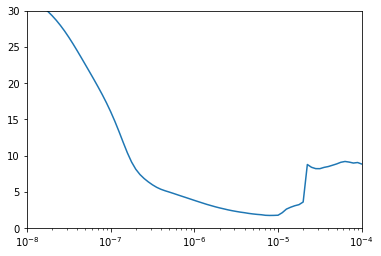

In [59]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [64]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=2e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=0)

In [65]:
rnn_forecast = model_forecast(model, temps.Temperature.values[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

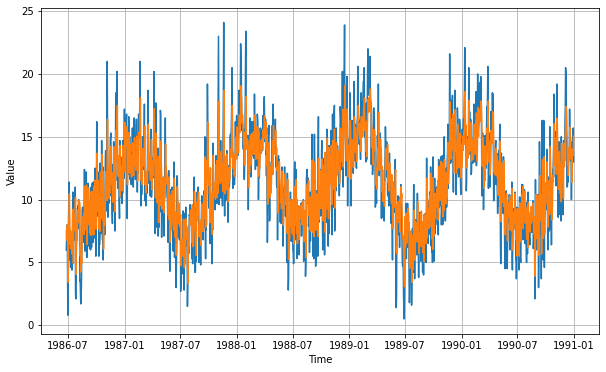

In [66]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [67]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.8561746

In [74]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule],verbose=0)

(1e-08, 0.0001, 0.0, 30.0)

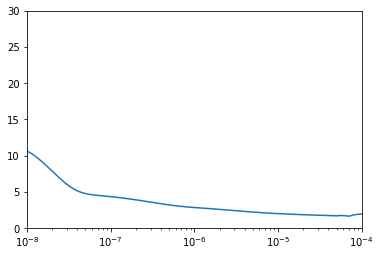

In [75]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [87]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 100)
])

optimizer = tf.keras.optimizers.SGD(lr=2e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=0)

In [88]:
rnn_forecast = model_forecast(model, temps.Temperature.values[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

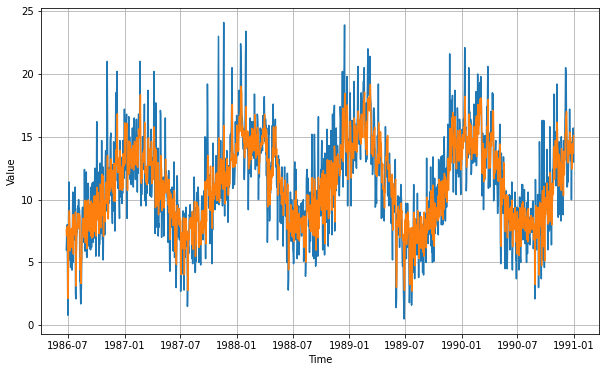

In [89]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [90]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.8136395

### Add $\ell_2$ regularization

In [91]:
from functools import partial

In [92]:
RegularizedLSTM = partial(keras.layers.LSTM,
                          return_sequences=True,
                          kernel_regularizer=keras.regularizers.l2(1e-4),
                          recurrent_regularizer=keras.regularizers.l2(1e-4))

In [97]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  RegularizedLSTM(64, input_shape=[None, 1]),
  RegularizedLSTM(64, input_shape=[None, 1]),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 100)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=400,verbose=0)

In [98]:
rnn_forecast = model_forecast(model, temps.Temperature.values[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

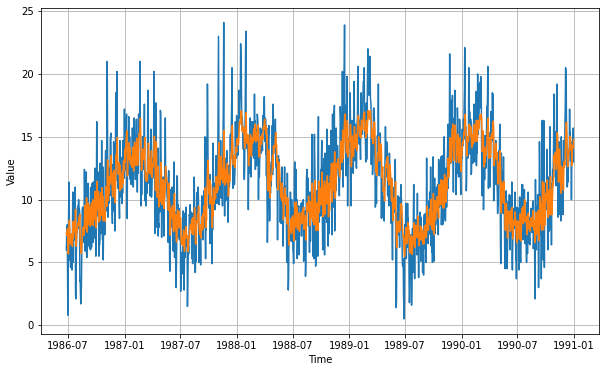

In [99]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [100]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.8836952